In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid

from recsys4daos.models import NLPSimilarity
from recsys4daos.utils import Timer
from recsys4daos.datasets import to_microsoft
from recsys4daos.evaluation import calculate_all_metrics
from recsys4daos.model_selection import cvtt_open, explore_hparams

import paths

import seaborn as sns
sns.set_theme()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/daviddavo/recsys4daos/.direnv/python-3.11/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Parameters

In [2]:
# Dataset config
ORG_NAME = 'Decentraland'

# Evaluation
K_RECOMMENDATIONS: list[int] = [1,3,5,10,15,100]
SPLITS_FREQ: str = 'W-THU' # split weekly
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00
LAST_FOLDS = 10 # Use just last 10 splits
LAST_FOLD_DATE_STR: str = None

# Search space config
WINDOW_SIZES = ['7d', '14d', '21d', '30d', '60d', '90d', '10YE']
MODEL_NAMES = [
    'all-mpnet-base-v2', # The one used in sbert's examples
    'all-distilroberta-v1',
    'all-MiniLM-L12-v2',
    'all-MiniLM-L6-v2',
]

OPTIM_METRIC = 'map@10'

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "HUWA-DAO"
SPLITS_FREQ = "2d"
LAST_FOLDS = 6
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2021-11-13"


In [4]:
EMBEDDINGS_CACHE = Path(paths.DEFAULT_CACHE_PATH) / 'pln-embeddings'

# Load the dataset

In [5]:
dfp = paths.load_proposals(ORG_NAME, text=True)
dfv = paths.load_votes(ORG_NAME)

print(dfp.info())
print(dfv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631 entries, 0 to 630
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 631 non-null    object        
 1   author             631 non-null    object        
 2   date               631 non-null    datetime64[us]
 3   start              631 non-null    datetime64[us]
 4   end                631 non-null    datetime64[us]
 5   platform_proposal  631 non-null    object        
 6   title              631 non-null    object        
 7   description        631 non-null    object        
dtypes: datetime64[us](3), object(5)
memory usage: 39.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4151 entries, 0 to 4150
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        4151 non-null   object        
 1   proposal  4151 non-null   object

In [6]:
df = to_microsoft(dfv)
df

,userID,itemID,timestamp,rating
0,0x7452e7d530078dbd6a2ed65007bea00a4d60f138,7f78eca6-a122-5074-ad86-268642177a4b,2021-07-22 11:44:39,1
1,0x2245be89fc8fab94ed982e859aa3212a4e4eb7e5,7f78eca6-a122-5074-ad86-268642177a4b,2021-07-22 11:48:19,1
2,0x5f527da3f5d3107423080165ed5452c94940c812,7f78eca6-a122-5074-ad86-268642177a4b,2021-07-22 11:48:38,1
3,0xd903839f391b169becc0a9d5aa98e26a06542cd0,7f78eca6-a122-5074-ad86-268642177a4b,2021-07-22 11:53:23,1
4,0xab7b49bacd43bd4cfa41433d477f690bb9e1fb26,7f78eca6-a122-5074-ad86-268642177a4b,2021-07-22 11:57:02,1
...,...,...,...,...
4146,0x20d801dbee0505f9a77cff40f5fed6ff0f0ee9d6,ccddcdaf-d162-54c1-9714-f10b876ff38b,2023-06-30 14:01:01,1
4147,0x20d801dbee0505f9a77cff40f5fed6ff0f0ee9d6,2ef1f8a7-ecd9-5064-b846-c1b2204d2faa,2023-06-30 14:01:29,1
4148,0x6404f1952d58a748d10e8747bd621714e873da0d,ccddcdaf-d162-54c1-9714-f10b876ff38b,2023-07-01 00:50:21,1
4149,0x6404f1952d58a748d10e8747bd621714e873da0d,7ada4be8-5590-58c0-b9b6-891cd28635ac,2023-07-01 00:50:56,1


## Split in folds

In [7]:
all_folds = { f.end:f for f in cvtt_open(
    df, SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', last_fold=LAST_FOLD_DATE_STR,
)}
last_folds_idx = list(all_folds.keys())[-LAST_FOLDS:]
last_folds_idx

[Timestamp('2021-11-03 00:00:00'),
 Timestamp('2021-11-05 00:00:00'),
 Timestamp('2021-11-07 00:00:00'),
 Timestamp('2021-11-09 00:00:00'),
 Timestamp('2021-11-11 00:00:00'),
 Timestamp('2021-11-13 00:00:00')]

# Similarity PLN

In [8]:
def testHParamsPLNSimilarity(fold, window_size, model_name):
    f = all_folds[fold]
    
    model = NLPSimilarity(dfp, EMBEDDINGS_CACHE, model_name=model_name)

    offset = pd.tseries.frequencies.to_offset(window_size)
    train = f.train[f.train['timestamp'] > (f.end - offset)]

    with Timer() as t_fit:
        model.fit(train)

    with Timer() as t_rec:
        # Truncate the top_k
        top_k = max(K_RECOMMENDATIONS)
        users = np.intersect1d(f.test['userID'].unique(), train['userID'].unique())
        recs = model.recommend_k_items(users, top_k=min(len(f.open_proposals), top_k), recommend_from=f.open_proposals)
    
    return {
        'time_train': t_fit.time,
        'time_rec': t_rec.time,
        'rec_users': len(users),
        **calculate_all_metrics(f.test, recs, K_RECOMMENDATIONS),
    }

# testHParamsPLNSimilarity(last_folds_idx[0], '14D', MODEL_NAMES[0])

In [9]:
# Populate the cache of embeddings for each model
from recsys4daos.models.nlp import NLPModel

for m in MODEL_NAMES:
    NLPModel(dfp, EMBEDDINGS_CACHE, model_name=m).fit()

In [10]:
results = explore_hparams(
    testHParamsPLNSimilarity,
    ParameterGrid({
        'fold': last_folds_idx,
        'model_name': MODEL_NAMES,
        'window_size': WINDOW_SIZES,
    }),
    paths.hparams_progress('pln-similarity', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE),
)
mdf = pd.DataFrame(results)
mdf

Restored checkpoint from ../.cache/HUWA-DAO/hparams-pln-similarity_2d_normalize.pkl with 168 results


  0%|          | 0/168 [00:00<?, ?it/s]

,fold,model_name,window_size,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
0,2021-11-03,all-mpnet-base-v2,7d,0.242279,0.001388,3,0.333333,0.222222,0.266667,0.300000,...,0.247475,0.277778,1.0,0.030303,0.060606,0.121212,0.242424,0.333333,0.787879,0.128020
1,2021-11-03,all-mpnet-base-v2,14d,0.096518,0.001443,6,0.166667,0.111111,0.166667,0.183333,...,0.345960,0.361111,1.0,0.030303,0.060606,0.121212,0.242424,0.333333,0.787879,0.128177
2,2021-11-03,all-mpnet-base-v2,21d,0.246769,0.001403,6,0.166667,0.111111,0.166667,0.183333,...,0.345960,0.361111,1.0,0.030303,0.060606,0.121212,0.242424,0.333333,0.787879,0.127950
3,2021-11-03,all-mpnet-base-v2,30d,0.096087,0.001382,6,0.166667,0.111111,0.166667,0.183333,...,0.345960,0.361111,1.0,0.030303,0.060606,0.121212,0.242424,0.333333,0.787879,0.127741
4,2021-11-03,all-mpnet-base-v2,60d,0.246822,0.002559,6,0.166667,0.111111,0.166667,0.183333,...,0.345960,0.361111,1.0,0.030303,0.060606,0.121212,0.242424,0.333333,0.787879,0.128025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2021-11-13,all-MiniLM-L6-v2,21d,0.141273,0.001811,10,0.000000,0.000000,0.000000,0.010000,...,0.050000,0.050000,1.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.116704
164,2021-11-13,all-MiniLM-L6-v2,30d,0.283797,0.001823,10,0.000000,0.000000,0.000000,0.010000,...,0.050000,0.050000,1.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.116121
165,2021-11-13,all-MiniLM-L6-v2,60d,0.288701,0.001876,10,0.000000,0.000000,0.000000,0.010000,...,0.050000,0.050000,1.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.115970
166,2021-11-13,all-MiniLM-L6-v2,90d,0.138955,0.001784,10,0.000000,0.000000,0.000000,0.010000,...,0.050000,0.050000,1.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.116314


<Axes: xlabel='window_size', ylabel='map@10'>

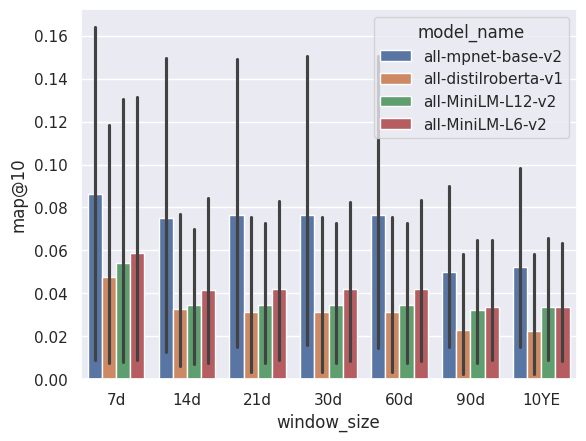

In [11]:
sns.barplot(mdf, x='window_size', y=OPTIM_METRIC, hue='model_name')

## Best overall hparams

In [12]:
display_columns = ['time_train'] + [ c for c in mdf.columns if c.endswith('@5') or c.endswith('@10') or c.endswith('@100') ]
hparam_cols = ['window_size', 'model_name']
overall_hparams = mdf[mdf['fold'] > last_folds_idx[0]].groupby(hparam_cols).mean().sort_values(OPTIM_METRIC, ascending=False)
overall_hparams[display_columns]

,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
window_size,model_name,,,,,,,,,,,,,,,,
60d,all-mpnet-base-v2,0.265025,0.025267,0.022637,0.017803,0.071799,0.076839,0.251971,0.059774,0.059712,0.088233,0.069593,0.085604,0.938594,0.631579,0.644737,0.664474
21d,all-mpnet-base-v2,0.234371,0.025267,0.022637,0.017803,0.071799,0.076839,0.251966,0.059774,0.059712,0.088232,0.069593,0.085604,0.938594,0.631579,0.644737,0.664474
30d,all-mpnet-base-v2,0.233630,0.025267,0.022637,0.017803,0.071799,0.076839,0.251971,0.059774,0.059712,0.088233,0.069593,0.085604,0.938594,0.631579,0.644737,0.664474
14d,all-mpnet-base-v2,0.204982,0.026211,0.023109,0.017875,0.069390,0.074431,0.238929,0.058061,0.057999,0.087385,0.071955,0.087965,0.938594,0.763158,0.789474,0.828947
7d,all-mpnet-base-v2,0.212118,0.023238,0.021802,0.017684,0.063052,0.068093,0.200366,0.055358,0.055372,0.083375,0.064659,0.081333,0.937405,0.508772,0.526316,0.828947
10YE,all-mpnet-base-v2,0.208826,0.033267,0.026761,0.017803,0.056591,0.060865,0.234154,0.034090,0.033640,0.062231,0.075308,0.091935,0.938594,0.365915,0.383459,0.409774
90d,all-mpnet-base-v2,0.235557,0.033267,0.026761,0.017803,0.056591,0.060856,0.234097,0.034090,0.033633,0.062181,0.075308,0.091935,0.938594,0.365915,0.383459,0.409774
7d,all-MiniLM-L6-v2,0.171034,0.029165,0.025420,0.016058,0.035828,0.043640,0.165662,0.021490,0.024787,0.051619,0.069080,0.093905,0.899837,0.088816,0.139620,0.288377
21d,all-MiniLM-L6-v2,0.220190,0.027481,0.026267,0.016166,0.035828,0.047185,0.211902,0.019772,0.023781,0.050411,0.060692,0.093389,0.899805,0.088816,0.209430,0.288377


In [13]:
best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])
paths.save_model_results(best_avg_hparams, 'plnsim-best-avg', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_avg_hparams

Saved dataframe into /home/daviddavo/recsys4daos/data/output/HUWA-DAO/models/plnsim-best-avg_2d_normalize.parquet


/tmp/ipykernel_3815752/971293119.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])


,,,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
fold,window_size,model_name,,,,,,,,,,,,,,,,,,,,,
2021-11-03,60d,all-mpnet-base-v2,0.246822,0.002559,6,0.166667,0.111111,0.166667,0.183333,0.155556,0.068333,0.111111,...,0.345960,0.361111,1.000000,0.030303,0.060606,0.121212,0.242424,0.333333,0.787879,0.128025
2021-11-05,60d,all-mpnet-base-v2,0.271168,0.002283,5,0.400000,0.133333,0.080000,0.080000,0.066667,0.044000,0.400000,...,0.231579,0.242105,0.879699,0.526316,0.526316,0.526316,0.578947,0.605263,0.657895,0.154620
2021-11-07,60d,all-mpnet-base-v2,0.143483,0.004108,162,0.006173,0.006173,0.008642,0.010494,0.010288,0.009938,0.006173,...,0.092593,0.138889,0.813272,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.364864
2021-11-09,60d,all-mpnet-base-v2,0.302622,0.002093,26,0.000000,0.000000,0.007692,0.007692,0.010256,0.013077,0.000000,...,0.028846,0.060897,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.148155
2021-11-11,60d,all-mpnet-base-v2,0.303337,0.001970,20,0.000000,0.016667,0.010000,0.005000,0.010000,0.011000,0.000000,...,0.025000,0.125000,1.000000,0.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.144500
2021-11-13,60d,all-mpnet-base-v2,0.304513,0.001849,10,0.000000,0.033333,0.020000,0.010000,0.013333,0.011000,0.000000,...,0.050000,0.150000,1.000000,0.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.130461


## best hparams by fold

In [14]:
print("Best hyperparams by fold", OPTIM_METRIC)
best_hparams = mdf.sort_values(OPTIM_METRIC,ascending=False).drop_duplicates(['fold'], keep='first').sort_values('fold').set_index(['fold', 'model_name', 'window_size'])
paths.save_model_results(best_hparams, 'plnsim-best-val', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_hparams[display_columns]

Best hyperparams by fold map@10
Saved dataframe into /home/daviddavo/recsys4daos/data/output/HUWA-DAO/models/plnsim-best-val_2d_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2021-11-03,all-mpnet-base-v2,7d,0.242279,0.266667,0.300000,0.120000,0.087335,0.111798,0.163648,0.214444,0.240370,0.312143,0.040404,0.247475,1.000000,0.121212,0.242424,0.787879
2021-11-05,all-mpnet-base-v2,7d,0.120472,0.080000,0.080000,0.044000,0.267832,0.272422,0.436812,0.240000,0.232667,0.263526,0.210526,0.231579,0.879699,0.526316,0.578947,0.657895
2021-11-07,all-MiniLM-L12-v2,10YE,0.291484,0.014815,0.012963,0.008765,0.027979,0.043440,0.163755,0.017803,0.024118,0.043203,0.048354,0.094136,0.704733,0.208333,0.208333,0.208333
2021-11-09,all-MiniLM-L12-v2,10YE,0.290686,0.023077,0.015385,0.012308,0.042387,0.047392,0.204495,0.028846,0.030220,0.049907,0.064103,0.073718,0.951923,0.333333,0.333333,0.333333
2021-11-11,all-MiniLM-L6-v2,7d,0.257055,0.018182,0.009091,0.010909,0.019343,0.019343,0.119958,0.018182,0.018182,0.047542,0.090909,0.090909,1.000000,NaN,NaN,NaN
2021-11-13,all-mpnet-base-v2,10YE,0.156580,0.020000,0.010000,0.011000,0.038685,0.038685,0.229352,0.025000,0.025000,0.057267,0.050000,0.050000,1.000000,0.500000,0.500000,0.500000


In [15]:
best_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,5.000000,5.000000,5.000000
mean,0.226426,0.070457,0.071240,0.034497,0.080593,0.088847,0.219670,0.090713,0.095093,0.128931,0.084049,0.131303,0.922726,0.337839,0.372608,0.497488
std,0.071633,0.099206,0.115357,0.043964,0.094699,0.095241,0.112856,0.106130,0.109642,0.124126,0.064467,0.085429,0.116738,0.177157,0.161463,0.234851
min,0.120472,0.014815,0.009091,0.008765,0.019343,0.019343,0.119958,0.017803,0.018182,0.043203,0.040404,0.050000,0.704733,0.121212,0.208333,0.208333
25%,0.178005,0.018636,0.010741,0.010932,0.030655,0.039874,0.163674,0.019886,0.024338,0.048133,0.048765,0.078016,0.897755,0.208333,0.242424,0.333333
50%,0.249667,0.021538,0.014174,0.011654,0.040536,0.045416,0.184125,0.026923,0.027610,0.053587,0.057051,0.092522,0.975962,0.333333,0.333333,0.500000
75%,0.282278,0.065769,0.063846,0.036077,0.076098,0.095696,0.223138,0.168045,0.182055,0.211961,0.084207,0.197218,1.000000,0.500000,0.500000,0.657895
max,0.291484,0.266667,0.300000,0.120000,0.267832,0.272422,0.436812,0.240000,0.240370,0.312143,0.210526,0.247475,1.000000,0.526316,0.578947,0.787879


### Results of using best hparams on next fold

In [16]:
next_hparams_idx = best_hparams.index.to_frame(False)
next_hparams_idx['fold'] = next_hparams_idx['fold'].shift(-1)
next_hparams_idx = next_hparams_idx.dropna()
assert len(next_hparams_idx) == len(best_hparams)-1
next_hparams = mdf.set_index(['fold', 'model_name', 'window_size']).loc[pd.MultiIndex.from_frame(next_hparams_idx)]
paths.save_model_results(next_hparams, 'plnsim-best-test', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
next_hparams[display_columns]

Saved dataframe into /home/daviddavo/recsys4daos/data/output/HUWA-DAO/models/plnsim-best-test_2d_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2021-11-05,all-mpnet-base-v2,7d,0.120472,0.080000,0.080000,0.044000,0.267832,0.272422,0.436812,0.240000,0.232667,0.263526,0.210526,0.231579,0.879699,0.526316,0.578947,0.657895
2021-11-07,all-mpnet-base-v2,7d,0.290045,0.008917,0.010828,0.009873,0.022976,0.039071,0.172133,0.017091,0.023235,0.043316,0.044586,0.095541,0.807325,1.000000,1.000000,1.000000
2021-11-09,all-MiniLM-L12-v2,10YE,0.290686,0.023077,0.015385,0.012308,0.042387,0.047392,0.204495,0.028846,0.030220,0.049907,0.064103,0.073718,0.951923,0.333333,0.333333,0.333333
2021-11-11,all-MiniLM-L12-v2,10YE,0.289934,0.000000,0.000000,0.011000,0.000000,0.000000,0.177192,0.000000,0.000000,0.019729,0.000000,0.000000,1.000000,0.000000,0.000000,NaN
2021-11-13,all-MiniLM-L6-v2,7d,0.084869,0.000000,0.000000,0.010000,0.000000,0.000000,0.099154,0.000000,0.000000,0.032425,0.000000,0.000000,1.000000,0.000000,0.000000,NaN


In [17]:
next_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000
mean,0.215201,0.022399,0.021243,0.017436,0.066639,0.071777,0.217957,0.057187,0.057224,0.081780,0.063843,0.080168,0.927789,0.371930,0.382456,0.663743
std,0.103495,0.033554,0.033532,0.014882,0.113858,0.114266,0.128408,0.102923,0.099012,0.102241,0.086658,0.094943,0.083420,0.417271,0.422767,0.333372
min,0.084869,0.000000,0.000000,0.009873,0.000000,0.000000,0.099154,0.000000,0.000000,0.019729,0.000000,0.000000,0.807325,0.000000,0.000000,0.333333
25%,0.120472,0.000000,0.000000,0.010000,0.000000,0.000000,0.172133,0.000000,0.000000,0.032425,0.000000,0.000000,0.879699,0.000000,0.000000,0.495614
50%,0.289934,0.008917,0.010828,0.011000,0.022976,0.039071,0.177192,0.017091,0.023235,0.043316,0.044586,0.073718,0.951923,0.333333,0.333333,0.657895
75%,0.290045,0.023077,0.015385,0.012308,0.042387,0.047392,0.204495,0.028846,0.030220,0.049907,0.064103,0.095541,1.000000,0.526316,0.578947,0.828947
max,0.290686,0.080000,0.080000,0.044000,0.267832,0.272422,0.436812,0.240000,0.232667,0.263526,0.210526,0.231579,1.000000,1.000000,1.000000,1.000000
